# Import

In [ ]:
import healpy as hp
from astropy.cosmology import Planck15
from pyoperators import MPI
import yaml
import numpy as np
import scipy.constants as const

from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.MapMaking.ComponentMapMaking.preset.preset import PresetInitialisation
from qubic.lib.MapMaking.NeuralNetworkMapMaking.operators.forward_ops import ForwardOps
from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Qsamplings import equ2gal, get_pointing
from qubic.lib.Qscene import QubicScene

comm = MPI.COMM_WORLDcond
%matplotlib inline


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/laclavere/miniconda3/envs/nn-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/laclavere/miniconda3/envs/nn-env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/laclavere/miniconda3/envs/nn-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/laclavere/miniconda3/envs/nn-env/lib/python3.10/site-packages/traitlets/config/applicat

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

# QUBIC Instances

In [ ]:
dictfilename = "qubic/qubic/dicts/pipeline_demo.dict"
d = qubicDict()
d.read_from_file(dictfilename)

center = equ2gal(d["RA_center"], d["DEC_center"])
d["nf_recon"] = 4
d["nf_sub"] = 4
d["MultiBand"] = True
d["nside"] = 128

d["synthbeam_kmax"] = 1
nf_sub = d["nf_sub"]
d["synthbeam_fraction"] = 1

d["use_synthbeam_fits_file"] = False
d["noiseless"] = True
d["photon_noise"] = False
d["npointings"] = 100
d["instrument_type"] = "UWB"
nf_recon = d["nf_recon"]

p = get_pointing(d)
s = QubicScene(d)
q = QubicInstrument(d)
acquisition = QubicAcquisition(q, p, s, d)

In [ ]:
params_file = "/home/laclavere/Thesis/qubic/qubic/scripts/MapMaking/src/NNMM/params.yml"
pipeline = PresetInitialisation(comm).initialize(params_file)

seenpix = pipeline.sky.seenpix
center = pipeline.sky.center

with open(params_file, "r") as tf:
            params = yaml.safe_load(tf)

========= Initialization =========
    => Reading parameters file
========= Initialization =========
    => Checking simulation parameters
    => No error detected !
    => Getting job ID
    => Creating folders
========= External Data =========
    => Computing Planck frequency bands
========= QUBIC =========
    => Reading QUBIC dictionary


SympifyError: SympifyError: None

# CMM Mixing Matrix

In [ ]:
nus = pipeline.mixingmatrix.nus_eff_in[:8]
beta = pipeline.mixingmatrix.beta_in
comps = pipeline.comp.components_model_in

In [ ]:
print("nus", nus, "\n", nus.shape, "\n")
print("beta", beta, "\n", beta.shape, "\n")
print("comps", comps, "\n", type(comps), "\n", comps.__len__())

nus [135.50540829 144.29216391 153.6486907  163.61193508 198.74126549
 211.62850707 225.35141303 239.96417145] 
 (8,) 

beta [1.54] 
 (1,) 

comps [1, 136779.6159441515*(0.00666666666666667*nu)**(beta_d + 1)*expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*(exp(0.00239962153668311*nu) - 1)*expm1(2.641300535699627)**2)] 
 <class 'list'> 
 2


In [ ]:
pipeline.mixingmatrix.Amm_in

array([[1.        , 0.790388  ],
       [1.        , 0.91237467],
       [1.        , 1.05979777],
       [1.        , 1.23964247],
       [1.        , 2.12296121],
       [1.        , 2.57724473],
       [1.        , 3.16492336],
       [1.        , 3.93578095],
       [1.        , 0.60182162],
       [1.        , 0.65873138],
       [1.        , 0.71986554],
       [1.        , 0.78556457],
       [1.        , 0.8561977 ],
       [1.        , 0.93216516],
       [1.        , 1.01390064],
       [1.        , 1.10187394],
       [1.        , 1.19659392],
       [1.        , 1.29861159],
       [1.        , 1.62633099],
       [1.        , 1.83602336],
       [1.        , 2.07124257],
       [1.        , 2.33523549],
       [1.        , 2.63166526],
       [1.        , 2.96466503],
       [1.        , 3.33889863],
       [1.        , 3.75962916],
       [1.        , 4.23279655],
       [1.        , 4.76510525]])

# NNMM Mixing Matrix

In [ ]:
forward_ops = ForwardOps(q, acquisition, s)
mm = forward_ops.op_mixing_matrix(nus, beta, comps)

In [ ]:
mm

array([[1.        , 0.79038788],
       [1.        , 0.9123747 ],
       [1.        , 1.05979761],
       [1.        , 1.23964247],
       [1.        , 2.12296115],
       [1.        , 2.57724477],
       [1.        , 3.16492312],
       [1.        , 3.93578094]])

# Test inverse Mixing Matrix

In [ ]:
Tcmb = Planck15.Tcmb(0).value

# FGBuster definition
h_over_k = const.h * 1e9 / const.k   # <- MUST use this

def f_cmb(nu_GHz, T=Tcmb):
    x = h_over_k * nu_GHz / T
    return (np.expm1(x)**2) / (np.exp(x) * x**2)   # EXACT FGBuster formula

def f_dust(nu_GHz, beta=1.54, nu0_GHz=150., T=20):
    x  = h_over_k * nu_GHz  / T
    x0 = h_over_k * nu0_GHz / T

    part1 = (np.exp(x0) - 1) / (np.exp(x) - 1)
    part2 = (nu_GHz / nu0_GHz)**(1 + beta)
    part3 = f_cmb(nu_GHz) / f_cmb(nu0_GHz)

    return part1 * part2 * part3

# nus must be in GHz
Acmb = np.ones_like(nus)
Adust = f_dust(nus)
Amm = np.vstack([Acmb, Adust]).T

print(Amm)
print(Amm.shape)

[[1.         0.79038788]
 [1.         0.9123747 ]
 [1.         1.05979761]
 [1.         1.23964247]
 [1.         2.12296115]
 [1.         2.57724477]
 [1.         3.16492312]
 [1.         3.93578094]]
(8, 2)


In [ ]:
a = len(nus)
b = np.sum(f_dust(nus))
d = np.sum(f_dust(nus)**2)

inv_Amm_cmb = np.array([d - b*f_dust(nu_i) for nu_i in nus])
inv_Amm_dust = np.array([-b + a * f_dust(nu_i) for nu_i in nus])

inv_Amm = 1 / (a * d - b*b) * np.array([inv_Amm_cmb, inv_Amm_dust])
inv_Amm = np.linalg.pinv(Amm)

print(inv_Amm.shape)

(2, 8)


In [ ]:
a_T_a = 1 / (a * d - b * b) * np.array([[d, -b], [-b, a]])
print(np.linalg.cond(a_T_a))

29.08265428227547


In [ ]:
maps_comp = pipeline.comp.components_in
print(maps_comp.shape)

maps_freq = np.einsum('ac,cpb->apb', Amm, maps_comp)
print(maps_freq.shape)

(2, 196608, 3)
(8, 196608, 3)


In [ ]:
maps_comp_after_inv_mm = np.einsum('ca,apb->cpb', inv_Amm, maps_freq)

diff = maps_comp - maps_comp_after_inv_mm
print("mean diff (seenpix) =", np.mean(diff[:, seenpix]))
print("max abs diff (seenpix) =", np.max(np.abs(diff[:, seenpix])))
print("allclose (seenpix) =", np.allclose(maps_comp[:, seenpix], maps_comp_after_inv_mm[:, seenpix], atol=1e-8))

mean diff (seenpix) = -8.022901834468324e-16
max abs diff (seenpix) = 1.4210854715202004e-13
allclose (seenpix) = True


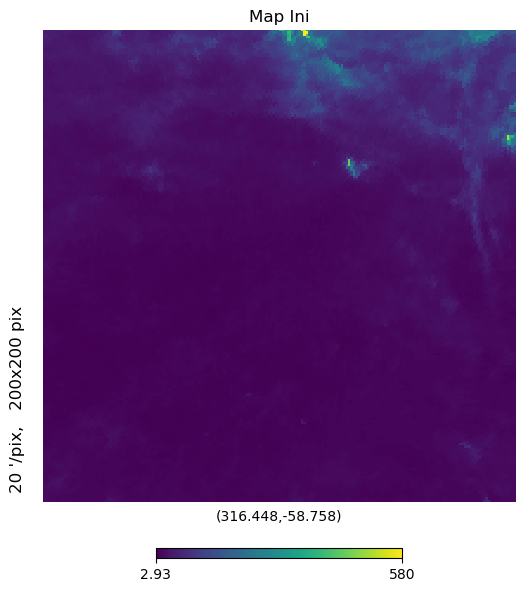

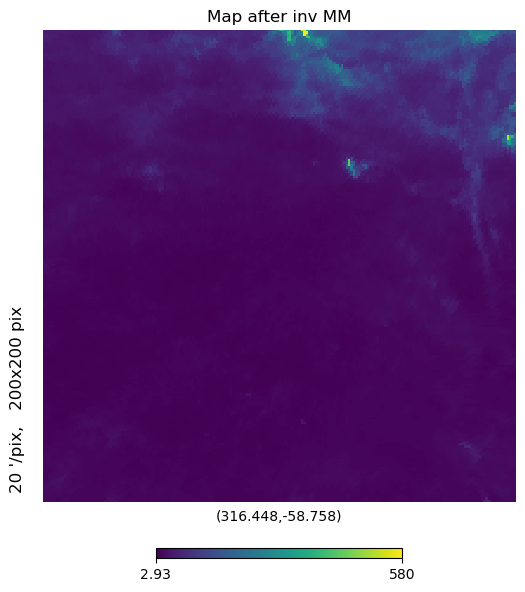

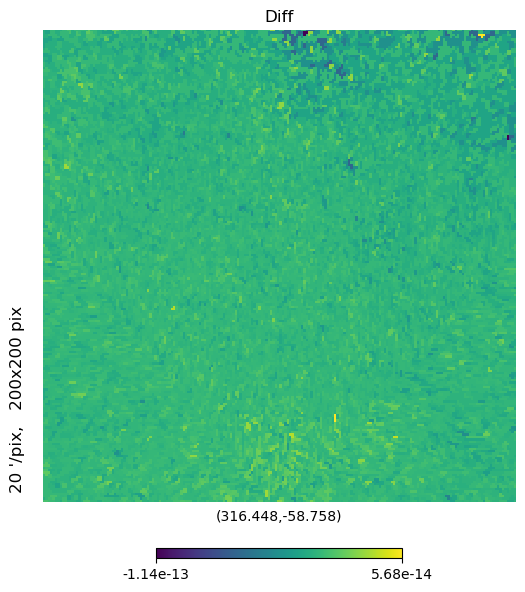

In [ ]:
hp.gnomview(maps_comp[1, :, 0], rot=center, reso=20, title="Map Ini")
hp.gnomview(maps_comp_after_inv_mm[1, :, 0], rot=center, reso=20, title="Map after inv MM")
hp.gnomview(maps_comp_after_inv_mm[1, :, 0] - maps_comp[1, :, 0], rot=center, reso=20, title="Diff")